<a href="https://colab.research.google.com/github/kocsis-david/LipReadingModel/blob/master/modeltrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import csv
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
def pd_save_data(lips, Y, data_type):
    with open(f'{data_type}_lips.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        header = ['label']
        for i in range(lips[0].shape[0]): #frames
            for j in range(lips[0].shape[1]): #height
                for k in range(lips[0].shape[2]): #width
                    header.append(f'pixel_{i}_{j}_{k}')
        writer.writerow(header)
        for i in range(len(lips)):
            row = [Y[i].argmax()]
            current_lips = lips[i].flatten()
            for j in range(len(current_lips)):
                row.append(current_lips[j])
            writer.writerow(row)


def pd_load_data():
    X_train = pd.read_csv('/content/drive/MyDrive/lips/train_lips.csv')
    Y_train = X_train['label']
    del X_train['label']
    X_valid = pd.read_csv('/content/drive/MyDrive/lips/valid_lips.csv')
    Y_valid = X_valid['label']
    del X_valid['label']

    X_test = pd.read_csv('/content/drive/MyDrive/lips/test_lips.csv')
    Y_test = X_test['label']
    del X_test['label']
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

In [1]:
!pip install pandas
!pip install scikit-learn

In [11]:
# loading the data from the csv files
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = pd_load_data()

Py4JJavaError: An error occurred while calling o44.csv.
: com.univocity.parsers.common.TextParsingException: java.lang.ArrayIndexOutOfBoundsException - Index 20480 out of bounds for length 20480
Parser Configuration: CsvParserSettings:
	Auto configuration enabled=true
	Auto-closing enabled=true
	Autodetect column delimiter=false
	Autodetect quotes=false
	Column reordering enabled=true
	Delimiters for detection=null
	Empty value=
	Escape unquoted values=false
	Header extraction enabled=null
	Headers=null
	Ignore leading whitespaces=false
	Ignore leading whitespaces in quotes=false
	Ignore trailing whitespaces=false
	Ignore trailing whitespaces in quotes=false
	Input buffer size=1048576
	Input reading on separate thread=false
	Keep escape sequences=false
	Keep quotes=false
	Length of content displayed on error=1000
	Line separator detection enabled=false
	Maximum number of characters per column=-1
	Maximum number of columns=20480
	Normalize escaped line separators=true
	Null value=
	Number of records to read=all
	Processor=none
	Restricting data in exceptions=false
	RowProcessor error handler=null
	Selected fields=none
	Skip bits as whitespace=true
	Skip empty lines=true
	Unescaped quote handling=STOP_AT_DELIMITERFormat configuration:
	CsvFormat:
		Comment character=#
		Field delimiter=,
		Line separator (normalized)=\n
		Line separator sequence=\n
		Quote character="
		Quote escape character=\
		Quote escape escape character=null
Internal state when error was thrown: line=0, column=20481, record=0, charIndex=280676
	at com.univocity.parsers.common.AbstractParser.handleException(AbstractParser.java:402)
	at com.univocity.parsers.common.AbstractParser.parseLine(AbstractParser.java:707)
	at org.apache.spark.sql.execution.datasources.csv.TextInputCSVDataSource$.$anonfun$inferFromDataset$1(CSVDataSource.scala:124)
	at scala.Option.map(Option.scala:230)
	at org.apache.spark.sql.execution.datasources.csv.TextInputCSVDataSource$.inferFromDataset(CSVDataSource.scala:124)
	at org.apache.spark.sql.execution.datasources.csv.TextInputCSVDataSource$.infer(CSVDataSource.scala:112)
	at org.apache.spark.sql.execution.datasources.csv.CSVDataSource.inferSchema(CSVDataSource.scala:64)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat.inferSchema(CSVFileFormat.scala:62)
	at org.apache.spark.sql.execution.datasources.DataSource.$anonfun$getOrInferFileFormatSchema$11(DataSource.scala:208)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.sql.execution.datasources.DataSource.getOrInferFileFormatSchema(DataSource.scala:205)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:407)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:229)
	at org.apache.spark.sql.DataFrameReader.$anonfun$load$2(DataFrameReader.scala:211)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:211)
	at org.apache.spark.sql.DataFrameReader.csv(DataFrameReader.scala:538)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:578)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1623)
Caused by: java.lang.ArrayIndexOutOfBoundsException: Index 20480 out of bounds for length 20480
	at com.univocity.parsers.common.ParserOutput.valueParsed(ParserOutput.java:373)
	at com.univocity.parsers.csv.CsvParser.parseSingleDelimiterRecord(CsvParser.java:189)
	at com.univocity.parsers.csv.CsvParser.parseRecord(CsvParser.java:109)
	at com.univocity.parsers.common.AbstractParser.parseLine(AbstractParser.java:687)
	... 27 more


In [ ]:
import numpy as np
x_train = np.array(X_train, dtype='float32').reshape(-1, 11, 60, 100, 1)
x_valid = np.array(X_valid, dtype='float32').reshape(-1, 11, 60, 100, 1)
x_test = np.array(X_test, dtype='float32').reshape(-1, 11, 60, 100, 1)

onehot_encoder = OneHotEncoder()

Y_train_reshaped = np.array(Y_train).reshape(-1, 1)
Y_valid_reshaped = np.array(Y_valid).reshape(-1, 1)
Y_test_reshaped = np.array(Y_test).reshape(-1, 1)

Y_train_onehot = onehot_encoder.fit_transform(Y_train_reshaped)
Y_valid_onehot = onehot_encoder.fit_transform(Y_valid_reshaped)
Y_test_onehot = onehot_encoder.fit_transform(Y_test_reshaped)

# Convert one-hot encoded arrays to dense arrays
Y_train = Y_train_onehot.toarray()
Y_valid = Y_valid_onehot.toarray()
Y_test = Y_test_onehot.toarray()

In [6]:
mean=x_train.mean(axis=0)
std=x_train.std(axis=0)

X_train=np.array((x_train-mean)/std)
x_train=None
X_valid=np.array((x_valid-mean)/std)
x_valid=None
X_test=np.array((x_test-mean)/std)
x_test=None

print(X_train.shape)


(4768, 11, 60, 100, 1)


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Input, \
    ReLU, GlobalAveragePooling3D, add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation

output_shape = 6
input = Input(shape=(11, 60, 100, 1))

'''block_0'''
b0_conv3d_1 = Conv3D(64, kernel_size=(2, 3, 3), padding='same', use_bias=False,
                     name='b0_conv3d_1', kernel_initializer='he_normal')(input)
b0_relu_1 = ReLU(name='b0_relu_1')(b0_conv3d_1)
b0_bn_1 = BatchNormalization(name='b0_bn_1')(b0_relu_1)
b0_out = MaxPooling3D(pool_size=(2, 2, 2))(b0_bn_1)

'''block_1'''
b1_cnv3d_1 = Conv3D(filters=16, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same',
                    use_bias=False, name='b1_cnv3d_1', kernel_initializer='he_normal')(b0_out)
b1_relu_1 = ReLU(name='b1_relu_1')(b1_cnv3d_1)
b1_bn_1 = BatchNormalization(name='b1_bn_1')(b1_relu_1)  # size: 14*14

b1_cnv3d_2 = Conv3D(filters=32, kernel_size=(1, 1, 1), strides=(2, 2, 2), padding='same',
                    use_bias=False, name='b1_cnv3d_2', kernel_initializer='he_normal')(b1_bn_1)
b1_relu_2 = ReLU(name='b1_relu_2')(b1_cnv3d_2)
b1_out = BatchNormalization(name='b1_out')(b1_relu_2)  # size: 14*14

'''block 2'''
b2_cnv3d_1 = Conv3D(filters=32, kernel_size=(1, 1, 1), strides=(1, 1, 1), padding='same',
                    use_bias=False, name='b2_cnv3d_1', kernel_initializer='he_normal')(b1_out)
b2_relu_1 = ReLU(name='b2_relu_1')(b2_cnv3d_1)
b2_bn_1 = BatchNormalization(name='b2_bn_1')(b2_relu_1)  # size: 14*14

b2_add = add([b1_out, b2_bn_1])  #

b2_cnv3d_2 = Conv3D(filters=64, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same',
                    use_bias=False, name='b2_cnv3d_2', kernel_initializer='he_normal')(b2_add)
b2_relu_2 = ReLU(name='b2_relu_2')(b2_cnv3d_2)
b2_out = BatchNormalization(name='b2_bn_2')(b2_relu_2)  # size: 7*7

'''block 3'''
b3_cnv3d_1 = Conv3D(filters=64, kernel_size=(1, 1, 1), strides=(1, 1, 1), padding='same',
                    use_bias=False, name='b3_cnv3d_1', kernel_initializer='he_normal')(b2_out)
b3_relu_1 = ReLU(name='b3_relu_1')(b3_cnv3d_1)
b3_bn_1 = BatchNormalization(name='b3_bn_1')(b3_relu_1)  # size: 7*7

b3_add = add([b2_out, b3_bn_1])  #

b3_cnv3d_2 = Conv3D(filters=128, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same',
                    use_bias=False, name='b3_cnv3d_2', kernel_initializer='he_normal')(b3_add)
b3_relu_2 = ReLU(name='b3_relu_2')(b3_cnv3d_2)
b3_out = BatchNormalization(name='b3_out')(b3_relu_2)  # size: 3*3

'''block 4'''
from tensorflow.keras.layers import Activation
activation = 'wavenet'
skip_connections = []
use_skip_connections = False
original_x = b3_out
b4_tempconv1 = Conv3D(filters=32, kernel_size=(2,2,2),dilation_rate=(1,1,1), padding='same')(b3_out)
if activation == 'norm_relu':
    x = Activation('relu')(b4_tempconv1)
    x = BatchNormalization(x)
elif activation == 'wavenet':
    tanh_out = Activation('tanh')(b4_tempconv1)
    sigm_out = Activation('sigmoid')(b4_tempconv1)
    x= tf.keras.layers.multiply([tanh_out, sigm_out])
else:
    x = Activation(activation)(b4_tempconv1)

b4_spatialdropout1d =tf.keras.layers.SpatialDropout3D(0.2)(x)

x = Conv3D(32, 1, padding='same')(b4_spatialdropout1d)
original_x= Conv3D(32, 1, padding='same')(original_x)
res_x = tf.keras.layers.add([original_x, x])
skip_connections.append(x)

original_x = res_x
b4_tempconv1 = Conv3D(filters=64, kernel_size=(2,2,2),dilation_rate=(2,2,2), padding='same')(res_x)
if activation == 'norm_relu':
    x = Activation('relu')(b4_tempconv1)
    x = BatchNormalization(x)
elif activation == 'wavenet':
    tanh_out = Activation('tanh')(b4_tempconv1)
    sigm_out = Activation('sigmoid')(b4_tempconv1)
    x= tf.keras.layers.multiply([tanh_out, sigm_out])
else:
    x = Activation(activation)(b4_tempconv1)

b4_spatialdropout1d =tf.keras.layers.SpatialDropout3D(0.2)(x)

x = Conv3D(32, 1, padding='same')(b4_spatialdropout1d)
original_x= Conv3D(32, 1, padding='same')(original_x)
res_x = tf.keras.layers.add([original_x, x])
skip_connections.append(x)

original_x = res_x
b4_tempconv1 = Conv3D(filters=128, kernel_size=(2,2,2),dilation_rate=(4,4,4), padding='same')(res_x)
if activation == 'norm_relu':
    x = Activation('relu')(b4_tempconv1)
    x = BatchNormalization(x)
elif activation == 'wavenet':
    tanh_out = Activation('tanh')(b4_tempconv1)
    sigm_out = Activation('sigmoid')(b4_tempconv1)
    x= tf.keras.layers.multiply([tanh_out, sigm_out])
else:
    x = Activation(activation)(b4_tempconv1)

b4_spatialdropout1d =tf.keras.layers.SpatialDropout3D(0.2)(x)

x = Conv3D(32, 1, padding='same')(b4_spatialdropout1d)
original_x= Conv3D(32, 1, padding='same')(original_x)
res_x = tf.keras.layers.add([original_x, x])
skip_connections.append(x)

if use_skip_connections:
    res_x = tf.keras.layers.add(skip_connections)

x=Activation('relu')(res_x)

flatten = Flatten()(x)
last_layer = Dense(128, activation='relu')(flatten)
output = Dense(output_shape, name='model_output', activation='softmax',
               kernel_initializer='he_uniform')(last_layer)
model = Model(input, output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 11, 60,    │          0 │ -                 │
│ (InputLayer)        │ 100, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b0_conv3d_1         │ (None, 11, 60,    │      1,152 │ input_layer_2[0]… │
│ (Conv3D)            │ 100, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b0_relu_1 (ReLU)    │ (None, 11, 60,    │          0 │ b0_conv3d_1[0][0] │
│                     │ 100, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b0_bn_1             │ (None, 11, 60,    │        256 │ b0_relu_1[0][0]   │
│ (BatchNormalizatio… │ 100, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 5, 30, 50, │          0 │ b0_bn_1[0][0]     │
│ (MaxPooling3D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b1_cnv3d_1 (Conv3D) │ (None, 3, 15, 25, │     27,648 │ max_pooling3d_2[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b1_relu_1 (ReLU)    │ (None, 3, 15, 25, │          0 │ b1_cnv3d_1[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b1_bn_1             │ (None, 3, 15, 25, │         64 │ b1_relu_1[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b1_cnv3d_2 (Conv3D) │ (None, 2, 8, 13,  │        512 │ b1_bn_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b1_relu_2 (ReLU)    │ (None, 2, 8, 13,  │          0 │ b1_cnv3d_2[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b1_out              │ (None, 2, 8, 13,  │        128 │ b1_relu_2[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b2_cnv3d_1 (Conv3D) │ (None, 2, 8, 13,  │      1,024 │ b1_out[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b2_relu_1 (ReLU)    │ (None, 2, 8, 13,  │          0 │ b2_cnv3d_1[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b2_bn_1             │ (None, 2, 8, 13,  │        128 │ b2_relu_1[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 2, 8, 13,  │          0 │ b1_out[0][0],     │
│                     │ 32)               │            │ b2_bn_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b2_cnv3d_2 (Conv3D) │ (None, 1, 4, 7,   │     55,296 │ add_10[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b2_relu_2 (ReLU)    │ (None, 1, 4, 7,   │          0 │ b2_cnv3d_2[0][0]

 Total params: 441,830 (1.69 MB)

 Trainable params: 441,030 (1.68 MB)

 Non-trainable params: 800 (3.12 KB)

In [6]:
model.save('model.dilatatedcovnet.keras')

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=10, restore_best_weights=True,
                                      min_delta=0.001)
model.fit(X_train, Y_train, batch_size=32, epochs=30, verbose=1, validation_data=(X_valid, Y_valid,), callbacks=[es])

Train on 4768 samples, validate on 241 samples
Epoch 1/30
4768/4768 [==============================] - 26s 6ms/sample - loss: 1.5952 - accuracy: 0.3440 - val_loss: 1.4133 - val_accuracy: 0.4149
Epoch 2/30
4768/4768 [==============================] - 25s 5ms/sample - loss: 1.1403 - accuracy: 0.5495 - val_loss: 1.2267 - val_accuracy: 0.5062
Epoch 3/30
4768/4768 [==============================] - 24s 5ms/sample - loss: 0.9173 - accuracy: 0.6518 - val_loss: 1.2214 - val_accuracy: 0.5311
Epoch 4/30
4768/4768 [==============================] - 25s 5ms/sample - loss: 0.7604 - accuracy: 0.7125 - val_loss: 1.2177 - val_accuracy: 0.5436
Epoch 5/30
4768/4768 [==============================] - 25s 5ms/sample - loss: 0.6459 - accuracy: 0.7513 - val_loss: 1.1900 - val_accuracy: 0.5934
Epoch 6/30
4768/4768 [==============================] - 24s 5ms/sample - loss: 0.5695 - accuracy: 0.7785 - val_loss: 1.3767 - val_accuracy: 0.5768
Epoch 7/30
4768/4768 [==============================] - 24s 5ms/sample 

In [ ]:
from sklearn.metrics import classification_report

preds = model.predict(X_test)

print(classification_report(np.argmax(Y_test,1),np.argmax(preds,1)))

              precision    recall  f1-score   support

           0       0.55      0.42      0.48        50
           1       0.68      0.69      0.68        36
           2       0.52      0.54      0.53        50
           3       0.41      0.50      0.45        28
           4       0.62      0.62      0.62        50
           5       0.41      0.45      0.43        31

    accuracy                           0.54       245
   macro avg       0.53      0.54      0.53       245
weighted avg       0.54      0.54      0.54       245


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf=confusion_matrix(np.argmax(Y_test,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=100)

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling3D,MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, \
    ReLU, GlobalAveragePooling3D, add
from tensorflow.keras.models import Model


output_shape = 6
input = Input(shape=(11, 60, 100, 1))

'''block_0'''
b0_conv3d_1 = Conv3D(64, kernel_size=(2, 3, 3), padding='same', use_bias=False,
                     name='b0_conv3d_1', kernel_initializer='he_normal')(input)
b0_relu_1 = ReLU(name='b0_relu_1')(b0_conv3d_1)
b0_bn_1 = BatchNormalization(name='b0_bn_1')(b0_relu_1)

"""Resnet blocks"""
class C2DResnetblock(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size, strides, dropout, **kwargs):
        super(C2DResnetblock, self).__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv2D(filters=out_channels, kernel_size=kernel_size, strides=strides,
                                            padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(filters=out_channels, kernel_size=kernel_size, strides=strides,
                                            padding='same', activation='relu')
        self.downsample = None
        self.out_channels = out_channels
        self.strides = strides
        self.dropout = tf.keras.layers.Dropout(dropout)

    def build(self, __input_shape):
        in_channels = __input_shape[-1]
        if in_channels != self.out_channels:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(filters=self.out_channels, kernel_size=(1,1), strides=self.strides))
            self.downsample.add(tf.keras.layers.BatchNormalization())


    def call(self, inputs, training=True):
        in_channels = inputs.shape[-1]
        residual = inputs

        x1 = self.conv1(inputs)
        x2 = self.conv2(x1)
        x3 = self.dropout(x2, training=training)
        if(x3.shape[-1]==residual.shape[-1]):
            x = x3 + residual
        else:
            x = x3 + self.downsample(residual)

        return x
maxpool3d = MaxPooling3D(pool_size=(1, 4, 4))(b0_bn_1)
reshaped = tf.keras.layers.Reshape((11, -1,64))(maxpool3d)
skip_connections = []
res_block1 = C2DResnetblock(256, (3, 3), 1, 0.5)(reshaped)
downsample = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), name="downsample1")(res_block1)
skip_connections.append(downsample)
res_block2 = C2DResnetblock(128, (4, 4), 1, 0.5)(res_block1)
downsample = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), name="downsample2")(res_block2)
skip_connections.append(downsample)
res_block3 = C2DResnetblock(128, (5, 5), 1, 0.5)(res_block2)
downsample = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1),name="downsample3")(res_block3)
skip_connections.append(downsample)
res_block4 = C2DResnetblock(64, (3, 3), 1, 0.5)(res_block3)
if len(skip_connections)>0:
    res_block4 = tf.keras.layers.add(skip_connections)

"""BiLSTM"""
maxpool2d=MaxPooling2D(pool_size=(1, 8))(res_block4)
reshaped2 = tf.keras.layers.Reshape((11, -1))(maxpool2d)
bi_lstm =tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True))(reshaped2)
dropout = tf.keras.layers.Dropout(0.5)(bi_lstm)
bi_lstm2 =tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256))(dropout)
dropout2 = tf.keras.layers.Dropout(0.5)(bi_lstm2)
last_layer = Dense(128, activation='relu')(dropout2)
output = Dense(output_shape, name='model_output', activation='softmax',
               kernel_initializer='he_uniform')(last_layer)
model = Model(input, output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "functional_70"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_63      │ (None, 11, 60,    │          0 │ -                 │
│ (InputLayer)        │ 100, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b0_conv3d_1         │ (None, 11, 60,    │      1,152 │ input_layer_63[0… │
│ (Conv3D)            │ 100, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b0_relu_1 (ReLU)    │ (None, 11, 60,    │          0 │ b0_conv3d_1[0][0] │
│                     │ 100, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b0_bn_1             │ (None, 11, 60,    │        256 │ b0_relu_1[0][0]   │
│ (BatchNormalizatio… │ 100, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_12    │ (None, 11, 15,    │          0 │ b0_bn_1[0][0]     │
│ (MaxPooling3D)      │ 25, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_29          │ (None, 11, 375,   │          0 │ max_pooling3d_12… │
│ (Reshape)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2d_resnetblock_60  │ (None, 11, 375,   │    755,456 │ reshape_29[0][0]  │
│ (C2DResnetblock)    │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2d_resnetblock_61  │ (None, 11, 375,   │    820,096 │ c2d_resnetblock_… │
│ (C2DResnetblock)    │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2d_resnetblock_62  │ (None, 11, 375,   │    819,456 │ c2d_resnetblock_… │
│ (C2DResnetblock)    │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ downsample1         │ (None, 11, 375,   │     16,448 │ c2d_resnetblock_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ downsample2         │ (None, 11, 375,   │      8,256 │ c2d_resnetblock_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ downsample3         │ (None, 11, 375,   │      8,256 │ c2d_resnetblock_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 11, 375,   │          0 │ downsample1[0][0… │
│                     │ 64)               │            │ downsample2[0][0… │
│                     │                   │            │ downsample3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 11, 46,    │          0 │ add_6[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_30          │ (None, 11, 2944)  │          0 │ max_pooling2d_10… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_21    │ (None, 11, 256)   │  3,146,752 │ reshape_30[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,693,190 (25.53 MB)

 Trainable params: 6,692,294 (25.53 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
es=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=10, restore_best_weights=True,
                                      min_delta=0.001)
model.fit(X_train, Y_train, batch_size=32, epochs=30, verbose=1, validation_data=(X_valid, Y_valid,), callbacks=[es])

In [ ]:
from sklearn.metrics import classification_report

preds = model.predict(X_test)

print(classification_report(np.argmax(Y_test,1),np.argmax(preds,1)))


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf=confusion_matrix(np.argmax(Y_test,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=100)

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Input, \
    ReLU, GlobalAveragePooling3D, add
from tensorflow.keras.models import Model


output_shape = 6
input = Input(shape=(11, 60, 100, 1))

'''block_0'''
b0_conv3d_1 = Conv3D(64, kernel_size=(2, 3, 3),strides=(1,2,3), padding='same', use_bias=False,
                     name='b0_conv3d_1', kernel_initializer='he_normal')(input)
b0_relu_1 = ReLU(name='b0_relu_1')(b0_conv3d_1)
b0_bn_1 = BatchNormalization(name='b0_bn_1')(b0_relu_1)


'''block_1'''
b1_cnv3d_1 = Conv3D(filters=16, kernel_size=(3, 3, 3) ,padding='same',
                    use_bias=False, name='b1_cnv3d_1', kernel_initializer='he_normal')(b0_bn_1)
b1_relu_1 = ReLU(name='b1_relu_1')(b1_cnv3d_1)
b1_bn_1 = BatchNormalization(name='b1_bn_1')(b1_relu_1)  # size: 14*14

b1_cnv3d_2 = Conv3D(filters=32, kernel_size=(1, 1, 1), padding='same',
                    use_bias=False, name='b1_cnv3d_2', kernel_initializer='he_normal')(b1_bn_1)
b1_relu_2 = ReLU(name='b1_relu_2')(b1_cnv3d_2)
b1_out = BatchNormalization(name='b1_out')(b1_relu_2)  # size: 14*14

'''block 2'''
b2_cnv3d_1 = Conv3D(filters=32, kernel_size=(1, 1, 1), strides=(1, 1, 1), padding='same',
                    use_bias=False, name='b2_cnv3d_1', kernel_initializer='he_normal')(b1_out)
b2_relu_1 = ReLU(name='b2_relu_1')(b2_cnv3d_1)
b2_bn_1 = BatchNormalization(name='b2_bn_1')(b2_relu_1)  # size: 14*14

b2_add = add([b1_out, b2_bn_1])  #

b2_cnv3d_2 = Conv3D(filters=64, kernel_size=(3, 3, 3), strides=(1, 3, 4),padding='same',
                    use_bias=False, name='b2_cnv3d_2', kernel_initializer='he_normal')(b2_add)
b2_relu_2 = ReLU(name='b2_relu_2')(b2_cnv3d_2)
b2_out = BatchNormalization(name='b2_out')(b2_relu_2)  # size: 7*7

'''block 3'''
b3_cnv3d_1 = Conv3D(filters=64, kernel_size=(1, 1, 1), strides=(1, 1, 1), padding='same',
                    use_bias=False, name='b3_cnv3d_1', kernel_initializer='he_normal')(b2_out)
b3_relu_1 = ReLU(name='b3_relu_1')(b3_cnv3d_1)
b3_bn_1 = BatchNormalization(name='b3_bn_1')(b3_relu_1)  # size: 7*7

b3_add = add([b2_out, b3_bn_1])  #

b3_cnv3d_2 = Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same',
                    use_bias=False, name='b3_cnv3d_2', kernel_initializer='he_normal')(b3_add)
b3_relu_2 = ReLU(name='b3_relu_2')(b3_cnv3d_2)
b3_out = BatchNormalization(name='b3_out')(b3_relu_2)  # size: 3*3

'''block 4'''

b4_cnv3d_1 = Conv3D(filters=64, kernel_size=(1, 1, 1), strides=(1, 1, 1), padding='same',
                    use_bias=False, name='b4_cnv3d_1', kernel_initializer='he_normal')(b3_out)
b4_relu_1 = ReLU(name='b4_relu_1')(b4_cnv3d_1)
b4_bn_1 = BatchNormalization(name='b4_bn_1')(b4_relu_1)  # size: 7*7

b4_add = add([b3_out, b4_bn_1])  #

b4_cnv3d_2 = Conv3D(filters=128, kernel_size=(3, 3, 3), strides=(1, 2, 2), padding='same',
                    use_bias=False, name='b4_cnv3d_2', kernel_initializer='he_normal')(b4_add)
b4_relu_2 = ReLU(name='b4_relu_2')(b4_cnv3d_2)
b4_out = BatchNormalization(name='b4_out')(b4_relu_2)


class Reshaper(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Reshaper, self).__init__(**kwargs)

    def call(self, inputs):
        # Perform your TensorFlow operations here
        # For example, let's say tf_fn is a function that reshapes the input tensor
        output = tf.reshape(inputs, (-1,11,25*128))  # Replace with your desired shape
        return output



class Expanddim(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Expanddim, self).__init__(**kwargs)

    def call(self, inputs):
        # Perform your TensorFlow operations here
        # For example, let's say tf_fn is a function that reshapes the input tensor
        output = tf.expand_dims(inputs, axis=-1)  # Replace with your desired shape
        return output

class SEAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SEAttention, self).__init__(**kwargs)
        self.lstm = tf.keras.layers.LSTM(128)
        self.global_avg_pool = tf.keras.layers.GlobalAveragePooling1D()
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dense2 = tf.keras.layers.Dense(128, activation='sigmoid')
    def call(self, inputs):
        # Perform your TensorFlow operations here
        # For example, let's say tf_fn is a function that reshapes the input tensor
        temp=self.lstm(inputs)
        x=Expanddim()(temp)
        x = self.global_avg_pool(x)
        x = self.dense1(x)
        x = self.dense2(x)
        output = tf.keras.layers.multiply([temp, x])
        return output

class TemporalBlock(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size, strides, dilation_rate, dropout, **kwargs):
        super(TemporalBlock, self).__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv1D(filters=out_channels, kernel_size=kernel_size, strides=strides,
                                            padding='causal', dilation_rate=dilation_rate, activation='relu')
        self.conv2 = tf.keras.layers.Conv1D(filters=out_channels, kernel_size=kernel_size, strides=strides,
                                            padding='causal', dilation_rate=dilation_rate, activation='relu')
        self.downsample = None
        self.out_channels = out_channels
        self.strides = strides
        self.dropout = tf.keras.layers.Dropout(dropout)

    def build(self, __input_shape):
        in_channels = __input_shape[-1]
        if in_channels != self.out_channels:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv1D(filters=self.out_channels, kernel_size=1, strides=self.strides))
            self.downsample.add(tf.keras.layers.BatchNormalization())



    def call(self, inputs, training=True):
        in_channels = inputs.shape[-1]
        residual = inputs

        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.dropout(x, training=training)
        if(x.shape[-1]==residual.shape[-1]):
            x = x + residual
        elif self.downsample is not None:
            x = x + self.downsample(residual)

        return x


reshaped=Reshaper()(b4_out)
temporal1=TemporalBlock(64, 4, 1, 2, 0.5)(reshaped)
sea=SEAttention()(temporal1)
upshape1=Expanddim()(sea)
temporal2=TemporalBlock(128, 8, 1, 4, 0.5)(upshape1)
sea2=SEAttention()(temporal2)
upshape2=Expanddim()(sea2)
temporal3=TemporalBlock(256, 8, 1, 8, 0.5)(upshape2)
sea3=SEAttention()(temporal3)
upshape3=Expanddim()(sea3)
temporal4=TemporalBlock(128, 8, 1, 10, 0.5)(upshape3)
flatten = Flatten()(temporal4)
output = Dense(output_shape, name='model_output', activation='softmax',
               kernel_initializer='he_uniform')(flatten)
model = Model(input, output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "functional_76"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_67      │ (None, 11, 60,    │          0 │ -                 │
│ (InputLayer)        │ 100, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b0_conv3d_1         │ (None, 11, 30,    │      1,152 │ input_layer_67[0… │
│ (Conv3D)            │ 34, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b0_relu_1 (ReLU)    │ (None, 11, 30,    │          0 │ b0_conv3d_1[0][0] │
│                     │ 34, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b0_bn_1             │ (None, 11, 30,    │        256 │ b0_relu_1[0][0]   │
│ (BatchNormalizatio… │ 34, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b1_cnv3d_1 (Conv3D) │ (None, 11, 30,    │     27,648 │ b0_bn_1[0][0]     │
│                     │ 34, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b1_relu_1 (ReLU)    │ (None, 11, 30,    │          0 │ b1_cnv3d_1[0][0]  │
│                     │ 34, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b1_bn_1             │ (None, 11, 30,    │         64 │ b1_relu_1[0][0]   │
│ (BatchNormalizatio… │ 34, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b1_cnv3d_2 (Conv3D) │ (None, 11, 30,    │        512 │ b1_bn_1[0][0]     │
│                     │ 34, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b1_relu_2 (ReLU)    │ (None, 11, 30,    │          0 │ b1_cnv3d_2[0][0]  │
│                     │ 34, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b1_out              │ (None, 11, 30,    │        128 │ b1_relu_2[0][0]   │
│ (BatchNormalizatio… │ 34, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b2_cnv3d_1 (Conv3D) │ (None, 11, 30,    │      1,024 │ b1_out[0][0]      │
│                     │ 34, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b2_relu_1 (ReLU)    │ (None, 11, 30,    │          0 │ b2_cnv3d_1[0][0]  │
│                     │ 34, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b2_bn_1             │ (None, 11, 30,    │        128 │ b2_relu_1[0][0]   │
│ (BatchNormalizatio… │ 34, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 11, 30,    │          0 │ b1_out[0][0],     │
│                     │ 34, 32)           │            │ b2_bn_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b2_cnv3d_2 (Conv3D) │ (None, 11, 10, 9, │     55,296 │ add_7[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b2_relu_2 (ReLU)    │ (None, 11, 10, 9, │          0 │ b2_cnv3d_2[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b2_out              │ (None, 11, 10, 9, │        256 │ b2_relu_2[0][0] 

 Total params: 2,839,302 (10.83 MB)

 Trainable params: 2,837,094 (10.82 MB)

 Non-trainable params: 2,208 (8.62 KB)

In [8]:
model.save('model.temporalblock.keras')

In [11]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=10, restore_best_weights=True,
                                      min_delta=0.001)
model.fit(X_train, Y_train, batch_size=32, epochs=30, verbose=1, validation_data=(X_valid, Y_valid,), callbacks=[es])

Epoch 1/30
 19/149 [==>...........................] - ETA: 6:49 - loss: 0.7514 - accuracy: 0.7023

KeyboardInterrupt: 

Eval

<Axes: >

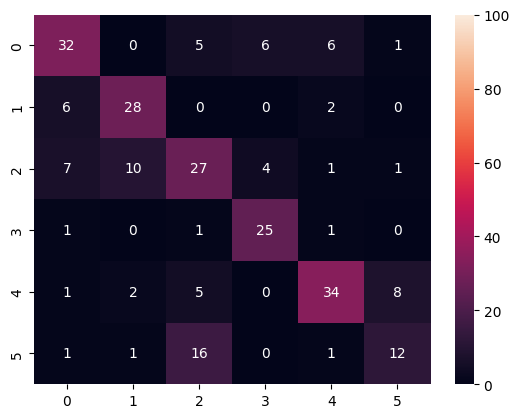

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf=confusion_matrix(np.argmax(Y_test,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=100)

In [13]:
from sklearn.metrics import classification_report

preds = model.predict(X_test)

print(classification_report(np.argmax(Y_test,1),np.argmax(preds,1)))

8/8 [==============================] - 6s 696ms/step
              precision    recall  f1-score   support

           0       0.77      0.66      0.71        50
           1       0.70      0.83      0.76        36
           2       0.42      0.60      0.50        50
           3       0.75      0.75      0.75        28
           4       0.81      0.70      0.75        50
           5       0.71      0.39      0.50        31

    accuracy                           0.66       245
   macro avg       0.69      0.66      0.66       245
weighted avg       0.69      0.66      0.66       245
